# 2.4 - Loss functions in Tensorflow

<a target="_blank" href="https://colab.research.google.com/github/rramosp/2021.deeplearning/blob/main/content/U2.04%20-%20Loss%20functions.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
%matplotlib inline

from keras import Sequential
from keras.layers import Dense, Input
from keras import Model
    
tf.__version__

### A sample dataset

A very simple regression task, with one input and one output

In [2]:
d = pd.read_csv("local/data/trilotropicos.csv")
y = d.densidad_escamas.values.astype(np.float32)
X = np.r_[[d.longitud.values]].T.astype(np.float32)
X.shape, y.shape

((150, 1), (150,))

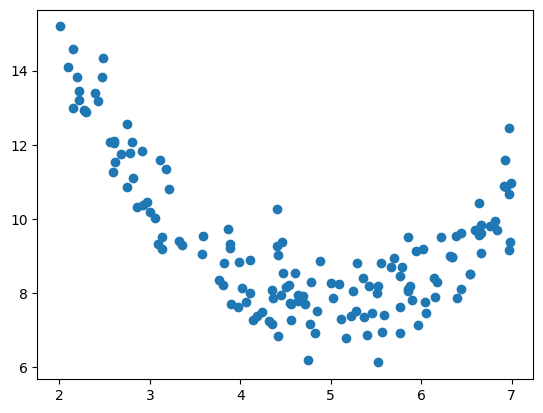

In [3]:
plt.scatter(X, y)
plt.show()

### Linear regression with Tensorflow Sequential API

Observe how we implement a standard **Linear Regression** model with Tensorflow **Sequential** model.

In [4]:

def get_model_sequential(loss):
    model = Sequential()
    model.add(Input(shape=(X.shape[-1],)))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=loss)
    return model  


In [5]:
model = get_model_sequential(loss="mse")
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.7891946]], dtype=float32), array([12.6691], dtype=float32)]

and we can always call the trained model on any input data to make new predictions

In [6]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[8.723127 ],
       [7.9339323],
       [7.1447377]], dtype=float32)

In [7]:
model.predict(np.r_[[[5],[6],[7]]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[8.723127 ],
       [7.9339323],
       [7.1447377]], dtype=float32)

the weights obtained are quite similar with the standard `scikit-learn` implementation

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
lr.coef_, lr.intercept_

(array([-0.7180587], dtype=float32), np.float32(12.689997))

note we are using the **predefined Mean Squared Error** loss function in Tensorflow

In [9]:
model = get_model_sequential(loss=tf.keras.losses.MSE)
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.66506994]], dtype=float32), array([12.68266], dtype=float32)]

In [10]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[9.35731 ],
       [8.692241],
       [8.02717 ]], dtype=float32)

We could have implemented ourselves. Recall we **MUST USE** Tensorflow operations.

In [11]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2, axis=-1)

In [12]:
model = get_model_sequential(loss=mse_loss)
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.70704436]], dtype=float32), array([12.656386], dtype=float32)]

In [13]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[9.121164],
       [8.41412 ],
       [7.707076]], dtype=float32)

You can even explicitly call the functions and check how they work

In [14]:
y_true  = np.random.random(size=5)
y_preds = np.random.random(size=y_true.shape)
y_true, y_preds

(array([0.50731617, 0.87191101, 0.48191568, 0.59040517, 0.83341053]),
 array([0.29028185, 0.48533997, 0.33551139, 0.54182448, 0.43307521]))

In [15]:
# numpy MSE
np.mean((y_true-y_preds)**2)

np.float64(0.07612074421712434)

In [16]:
# tf.keras MSE
tf.keras.losses.MSE(y_true, y_preds)

<tf.Tensor: shape=(), dtype=float64, numpy=0.07612074421712434>

In [17]:
# our implementation
mse_loss(y_true, y_preds)

<tf.Tensor: shape=(), dtype=float64, numpy=0.07612074421712434>

### Linear regression with Tensorflow Functional API

We can use the same mechanism with the Functional API

In [18]:
def get_model_functional_1(loss):
    inputs = Input(shape=(X.shape[-1],), name="input")
    outputs = Dense(1, activation='linear', name="output")(inputs)
    model = Model(inputs, outputs)    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=loss)
    return model  


In [19]:

model = get_model_functional_1(loss="mse")
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.8316052]], dtype=float32), array([12.640781], dtype=float32)]

In [20]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[8.482756],
       [7.65115 ],
       [6.819545]], dtype=float32)

In [21]:
model = get_model_functional_1(loss=tf.keras.losses.MSE)
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.67224115]], dtype=float32), array([12.704618], dtype=float32)]

In [22]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[9.343412 ],
       [8.671171 ],
       [7.9989305]], dtype=float32)

In [23]:
model = get_model_functional_1(loss=mse_loss)
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.7458604]], dtype=float32), array([12.664248], dtype=float32)]

In [24]:
model(np.r_[[[5],[6],[7]]]).numpy()

array([[8.934946],
       [8.189086],
       [7.443226]], dtype=float32)

However, when using the Functional API we have more flexibility. The following code is **an orthodox** way
of defining a supervised model, but it will be useful when dealing with Autoencoders later on to use them in an unsupervised manner. 

Observe the following aspects:

- We **DEFINE** our model to have two inputs: $X$ (on layer `inputs`) and $y$ (on layer `targets`).
- We **DEFINE** our model to have one output on layer `outputs` just like before. Observe that the new layer `targets` does not participate in producing this output.
- The `targets` layer only participates in computing the `loss` and, thus, it is only used during **TRAINING**, not on inference.

In [25]:
from keras.losses import Loss
def get_model_functional_2():
    inputs  = Input(shape=(X.shape[-1],), name="inputs")
    targets = Input(shape=(1,), name="targets")
    
    outputs = Dense(1, activation='linear', name="outputs")(inputs)
    model = Model([inputs, targets], [outputs])
    
    class my_loss(Loss):
        def call(self, outputs, targets):
            return tf.reduce_mean((outputs-targets)**2)
    
    loss = my_loss()
    model.compile(loss=loss,optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))
    return model  


observe how, due to this new architecture, the call to the `.fit` method now changes, although the results are the same.

In [26]:
model = get_model_functional_2()
model.fit([X,y],y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.08140875]], dtype=float32), array([9.577485], dtype=float32)]

**HOWEVER** when calling the model (inference) we **MUST** provide both $X$ and $y$, even if we know that $y$ will not be used (it is only used when training). Observe how the following call always yields the same result regardless the values of $y$. 

This is **INCONVENIENT** for a supervised model, but illustrates the flexibility of the functional API.

In [27]:
X = np.r_[[[5],[6],[7]]]
y = np.random.random(size=(3,1))
print (y)
model([X, y]).numpy()

[[0.48821399]
 [0.80019156]
 [0.63432008]]


array([[9.170442],
       [9.089032],
       [9.007624]], dtype=float32)

**ADVANCED METHODS**

When we want to add additional terms to the loss functions that depend on the activation of a layer, we have multiple choices:
- We can **INTEGRATE** the loss into the model by using directly **the model layers** and the `model.add_loss` method.
- We can use the [`activity_regulizer`](https://keras.io/api/layers/regularizers/) attribute of the layer when defining it.

In [33]:
class MyModel(Model):
    def __init__(self,alpha=0.1):
        super(MyModel, self).__init__()
        self.dense1 = Dense(1, activation='linear')
        self.alpha=tf.constant(alpha, dtype=tf.float32)
        
    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        self.add_loss(self.alpha*tf.reduce_mean(tf.square(inputs)))#inputs could be the output of a layer
        x = self.dense1(inputs)
        return x

model = MyModel()
model.compile(optimizer="adam", loss="mse")
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[-0.42082405]], dtype=float32), array([0.3484329], dtype=float32)]

In [34]:
model(X).numpy()

array([[-1.7556874],
       [-2.1765113],
       [-2.5973353]], dtype=float32)

If the loss function we want to implement contains several terms and requires access to targets and activations of inner layers, we can define our own train step, and also define our own training loop:

In [43]:
import keras
from keras import ops

# Your custom loss function
def custom_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    small_error = ops.abs(error) <= delta
    squared_loss = 0.5 * ops.square(error)
    linear_loss = delta * (ops.abs(error) - 0.5 * delta)
    return ops.mean(ops.where(small_error, squared_loss, linear_loss))

# Your new custom Model class
class CustomModel(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = Dense(1,activation='linear')
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.dense1(inputs)

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = custom_loss(y, y_pred, delta=0.5)
            
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` method works
        return [self.loss_tracker]

In [44]:
model = CustomModel()
model.compile(optimizer="adam", loss="mse")
model.fit(X,y, epochs=400, batch_size=16, verbose=0);
model.get_weights()

[array([[0.11249518]], dtype=float32), array([-0.03780845], dtype=float32)]

In [45]:
model(X).numpy()

array([[0.5246674 ],
       [0.63716257],
       [0.74965775]], dtype=float32)